In [69]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import os

In [70]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [71]:
images_path = r'D:\_DOCUMENTE_RARES\Desktop\ortho-vision\ai\resources\tufs_dental_databse\Radiographs'

In [72]:
masks_path = r'D:\_DOCUMENTE_RARES\Desktop\ortho-vision\ai\resources\tufs_dental_databse\Segmentation\teeth_mask'

In [73]:
def load_data(image_folder, mask_folder, size, img_size=(256, 256)):
    images = []
    masks = []
    for filename in os.listdir(image_folder):
        img = Image.open(os.path.join(image_folder, filename)).convert('L')
        img = img.resize(img_size)
        img = np.array(img) / 255.0  # normalize
        images.append(img)

        mask = Image.open(os.path.join(mask_folder, filename)).convert('L')
        mask = mask.resize(img_size)
        mask = np.array(mask) / 255.0  # normalize
        masks.append(mask)
        
        if len(images) == size and len(masks) == size:
            break
        
    images = np.expand_dims(images, axis=-1)
    masks = np.expand_dims(masks, axis=-1)
    return np.array(images), np.array(masks)

In [74]:
images, masks = load_data(images_path, masks_path, size=500)

In [75]:
images.shape, masks.shape

((500, 256, 256, 1), (500, 256, 256, 1))

In [76]:
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

In [90]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model


def unet_model():
    inputs = Input(shape=(256, 256, 1))
            
    # Encoder path
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(c5)

    # Decoder path
    u6 = UpSampling2D((2, 2))(c5)
    u6 = Concatenate()([u6, c4])
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(128, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = Concatenate()([u9, c1])
    c9 = Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(32, (3, 3), activation='relu', padding='same')(c9)

    # Output layer with a single channel for binary mask prediction
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    # Model
    model = Model(inputs, outputs)
    return model

In [91]:
unet = unet_model()

In [92]:
unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [93]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_29 (Conv2D)          (None, 256, 256, 32)         320       ['input_11[0][0]']            
                                                                                                  
 conv2d_30 (Conv2D)          (None, 256, 256, 32)         9248      ['conv2d_29[0][0]']           
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 128, 128, 32)         0         ['conv2d_30[0][0]']           
 g2D)                                                                                         

In [94]:
from tensorflow.keras.callbacks import ModelCheckpoint


checkpoint_callback = ModelCheckpoint(
    filepath='../checkpoints/tufs_unet_segmentation-{epoch:02d}.keras', 
    save_weights_only=True, 
    save_freq='epoch',
    verbose=1
)

In [95]:
# from keras.models import load_model

# unet = load_model(r'D:\_DOCUMENTE_RARES\Desktop\ortho-vision\ai\models\tufs_unet_segmentation.h5')
# unet.summary()

In [ ]:

history = unet.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=8,
    callbacks=[checkpoint_callback]
)


unet.save(r'D:\_DOCUMENTE_RARES\Desktop\ortho-vision\ai\models\tufs_unet_segmentation.keras')

Epoch 1/10
50/50 [==============================] - ETA: 0s - loss: 0.6278 - accuracy: 0.8495
Epoch 1: saving model to ../checkpoints\tufs_unet_segmentation-01.keras
50/50 [==============================] - 255s 5s/step - loss: 0.6278 - accuracy: 0.8495 - val_loss: 0.2323 - val_accuracy: 0.8571
Epoch 2/10
50/50 [==============================] - ETA: 0s - loss: 0.1866 - accuracy: 0.8634
Epoch 2: saving model to ../checkpoints\tufs_unet_segmentation-02.keras
50/50 [==============================] - 266s 5s/step - loss: 0.1866 - accuracy: 0.8634 - val_loss: 0.1807 - val_accuracy: 0.8571
Epoch 3/10
50/50 [==============================] - ETA: 0s - loss: 0.1750 - accuracy: 0.8634
Epoch 3: saving model to ../checkpoints\tufs_unet_segmentation-03.keras
50/50 [==============================] - 311s 6s/step - loss: 0.1750 - accuracy: 0.8634 - val_loss: 0.1780 - val_accuracy: 0.8571
Epoch 4/10
50/50 [==============================] - ETA: 0s - loss: 0.1718 - accuracy: 0.8635
Epoch 4: saving mo

d:\_DOCUMENTE_RARES\Desktop\ortho-vision\ai\venv\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [100]:
val_loss, val_accuracy = unet.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

4/4 [==============================] - 9s 2s/step - loss: 0.1410 - accuracy: 0.9247
Validation Loss: 0.14097216725349426, Validation Accuracy: 0.9247496128082275


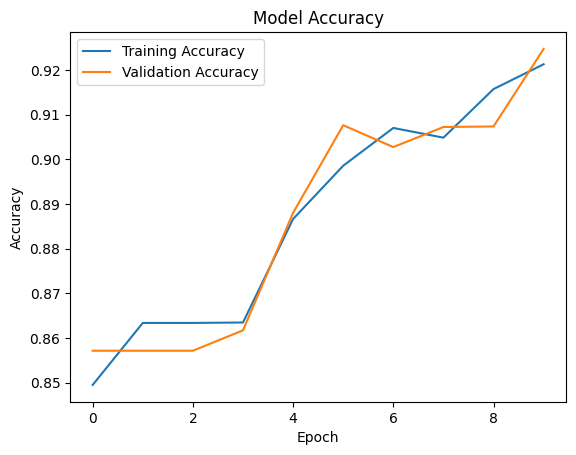

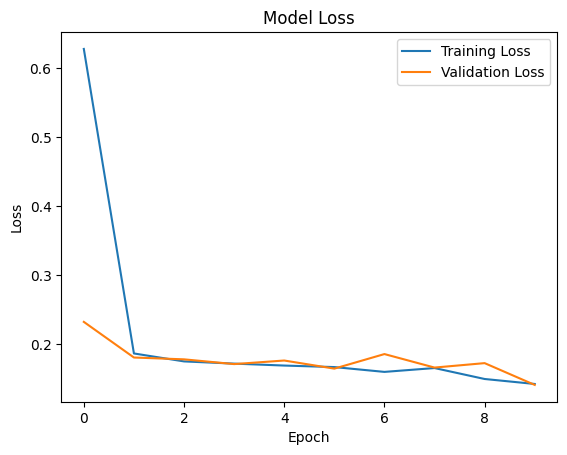

In [97]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

# Plot training & validation loss values
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.show()


In [98]:
def visualize_predictions(X, y_true, y_pred, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        # Display original image
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(X[i].squeeze(), cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        # Display true mask
        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(y_true[i].squeeze(), cmap='gray')
        plt.title('True Mask')
        plt.axis('off')

        # Display predicted mask
        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(y_pred[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

4/4 [==============================] - 10s 2s/step


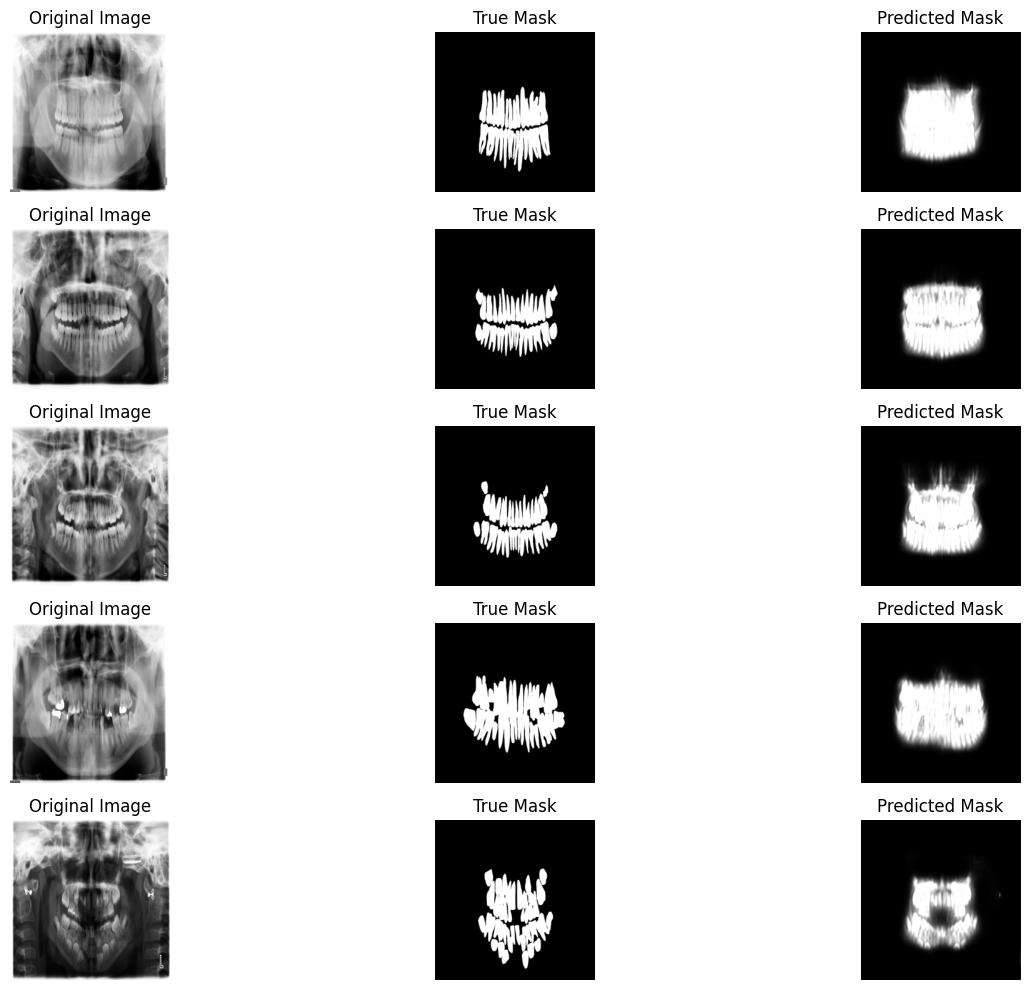

In [ ]:
predictions = unet.predict(X_val)
visualize_predictions(X_val, y_val, predictions)